In [1]:
import sys, os
# local_path = "/homes/s17ouala/Bureau/Sanssauvegarde/NbedDyn-main"
local_path = '/Users/matthewlevine/code_projects/NbedDyn'
sys.path.append(os.path.join(local_path, 'code/modules'))
import pickle
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA
import torch
from odelibrary        import *
from dynamical_models   import *
from generate_data      import *
from NbedDyn            import *
from stat_functions     import *
from pdb import set_trace as bp

In [2]:
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 110.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 0.0 # variance of the observation error to generate observation

# run the data generation
X_train_chaos = Attractor_Lorenz = np.load(os.path.join(local_path,'data/X_train_L63_CHAOS.npy'))
X_test  = np.load(os.path.join(local_path,'data/X_test_CHAOS.npy'))

In [3]:
d_obs      = 2
X_train    = X_train_chaos[:,:d_obs]#[:-1,:1]
Grad_t     = np.gradient(X_train,axis=0)/GD.dt_integration
Batch_size = X_train.shape[0]
nb_batch   = int(X_train.shape[0]/Batch_size)
X_train    = X_train.reshape(nb_batch,Batch_size,d_obs)
Grad_t     = Grad_t.reshape(nb_batch,Batch_size,d_obs)

In [4]:
# X_train    = X_train_chaos[:,:1]#[:-1,:1]
# Grad_t     = np.gradient(X_train[:,0]).reshape(X_train.shape[0],1)/GD.dt_integration
# Batch_size = X_train.shape[0]
# nb_batch   = int(X_train.shape[0]/Batch_size)
# X_train    = X_train.reshape(nb_batch,Batch_size,1)
# Grad_t     = Grad_t.reshape(nb_batch,Batch_size,1)

In [5]:
# in this run, we change the second/third terms of the original loss in Stage 1 so that they correspond to 1-step integrators
# we entirely omit Stage 2 of training
N_lat = 2
params = {}
params['nn_style']           = 'shallow'
params['use_f0']             = True
params['seed']               = 0
params['transition_layers']  = 1
params['bi_linear_layers']   = N_lat+d_obs
params['dim_hidden_linear']  = 500
params['dim_input']          = d_obs
params['dim_latent']         = N_lat
params['dim_observations']   = d_obs
params['dim_Embedding']      = N_lat+d_obs
params['ntrain']             = [10000,0]
params['dt_integration']     = 0.01
params['pretrained']         = False
params['nb_batch']           = nb_batch
params['Batch_size']         = Batch_size
params['get_latent_train']   = False
params['path']               = ''
params['file_name']          = 'NbedDyn_shallow_wider_lossCorrection1_debug_L63_2d_dim_'+str(params['dim_Embedding'])+'_seed_'+str(params['seed'])
model, modelRINN = get_NbedDyn_model(params)
model, modelRINN, aug_inp_data = train_NbedDyn_model_L63(params,model,modelRINN,X_train,Grad_t)

Loaded trained model!


In [6]:
y0 = torch.cat((torch.from_numpy(X_train).float()[-1,-1:,:], modelRINN.Dyn_net.y_aug[-1,-1:,:]), dim=1)
N_test_long = 20000

# integrate with solve_ivp
t_eval = GD.dt_integration*np.arange(-1, N_test_long+1)
t_span = [t_eval[0], t_eval[-1]]
settings= {'method': 'RK45'}
sol = my_solve_ivp( y0.data.numpy().reshape(-1), lambda t, y: model.rhs(y,t), t_eval, t_span, settings)

In [7]:
# old integration
pred = [y0]
for i in range(N_test_long):
    pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

In [8]:
forecasting_err=np.zeros(1000)
for i in range(1,100):
    forecasting_err[i-1]=RMSE(X_test[i-1,:d_obs],torch.stack(pred).data.numpy()[i,0,0])

In [9]:
print('prediction error at t0 + dt : '  ,forecasting_err[0])
print('prediction error at t0 + 4dt : ' ,forecasting_err[3])

prediction error at t0 + dt :  2.436922899249693
prediction error at t0 + 4dt :  2.529782976196842


In [26]:
torch.stack(pred).shape

torch.Size([20001, 1, 4])

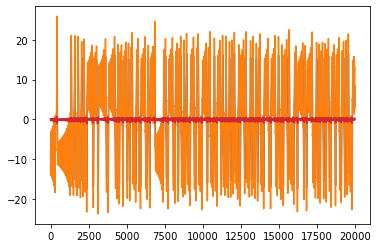

In [27]:
plt.plot(sol)

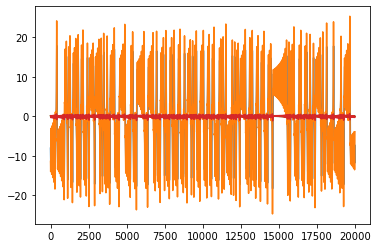

In [10]:
plt.plot(torch.stack(pred)[:,0,:].detach())

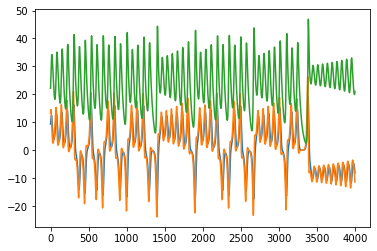

In [11]:
plt.plot(X_train_chaos)

# forecast at test time :
1) viz test time series

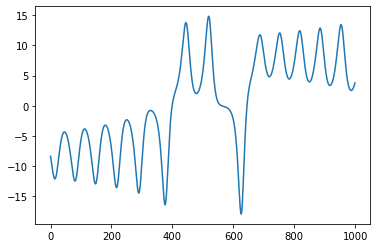

In [12]:
plt.plot(X_test[:,0])

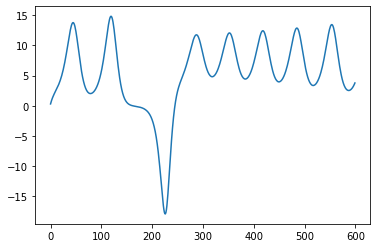

In [13]:
# forecast at starting from t0 = 400*dt :
plt.plot(X_test[400:,0])

# Simple method : find analogs for the latent states in the training set:

In [14]:
def get_init(test_vars,length_prior,dt,dim_aug):
    x = torch.from_numpy(X_train).float()
    aug_inp = torch.cat((x[0,:,:], modelRINN.Dyn_net.y_aug[0,:,:]), dim=1)
    pred, grad, inp, aug_inp = modelRINN(aug_inp,dt)
    pred, aug = model_Multi_RINN_simple(aug_inp, 0.0, length_prior, dt)
    loss_init=[]
    for i in range(aug_inp.shape[0]):
        loss_init.append(((pred[1:,i,:d_obs][torch.where(~torch.isnan(test_vars))]-test_vars[torch.where(~torch.isnan(test_vars))])**2).mean())
    min_idx = np.where(torch.stack(loss_init).data.numpy()==torch.stack(loss_init).data.numpy().min())
    inp_init = aug_inp.detach().data.numpy()[min_idx[0][0]].reshape(1,dim_aug)
    inp_init = (torch.from_numpy(inp_init).float())
    return inp_init
class Multi_INT_net(torch.nn.Module):
        def __init__(self, params):
            super(Multi_INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Int_net = modelRINN
        def forward(self, inp, t0, nb, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
#            dt = Variable(torch.from_numpy(np.reshape(dt,(1,1))).float())
#            x = Variable(3*torch.ones(1, 1), requires_grad=True)

            #grad, aug_inp = self.Dyn_net(inp,dt)
            #pred = aug_inp +dt*grad
            pred = [inp]
            aug  = []
            for i in range(nb):
                predic, k1, inp, aug_inp = self.Int_net(pred[-1], dt)
                pred.append(predic)
                aug.append(aug_inp)
            return torch.stack(pred), torch.stack(aug)
model_Multi_RINN_simple = Multi_INT_net(params)
criterion = torch.nn.MSELoss()

In [15]:
modelRINN.Dyn_net.y_aug.shape


torch.Size([1, 4000, 2])

In [16]:
initial_cond_idx = 400
length_prior     = 1 # length of the initial condition

test_vars = (torch.from_numpy(np.reshape(X_test[initial_cond_idx:initial_cond_idx+length_prior,:d_obs],(length_prior,d_obs))).float())
inp_init = get_init(test_vars,length_prior,0.01,params['dim_Embedding'])

y_pred2=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init
# integrate with solve_ivp
t_eval = GD.dt_integration*np.arange(-1, 2000+length_prior+1)
t_span = [t_eval[0], t_eval[-1]]
settings= {'method': 'RK45'}
sol2 = my_solve_ivp( inp_init.data.numpy().reshape(-1), lambda t, y: model.rhs(y,t), t_eval, t_span, settings)

#integrate old way
y_pred2[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred2[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[k,:],(1,params['dim_Embedding']))).float())

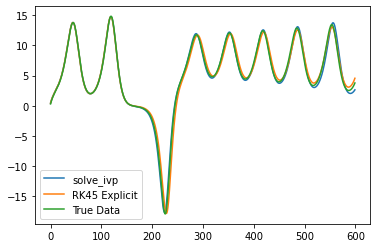

In [33]:
plt.plot(sol2[1:600+1,0],label='solve_ivp')
plt.plot(y_pred2[1:600+1,0], label='RK45 Explicit')
plt.plot(X_test[400:,0], label='True Data')
plt.legend()


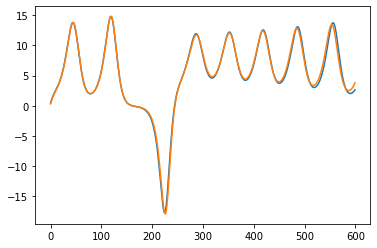

In [31]:
plt.plot(sol2[1:600+1,0])
plt.plot(X_test[400:,0])

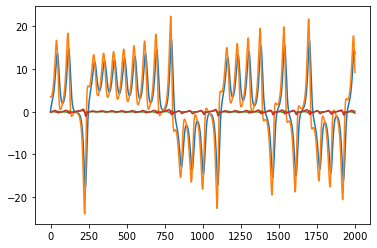

In [18]:
plt.plot(y_pred2[:,:])

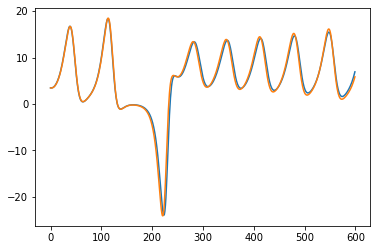

In [19]:
plt.plot(y_pred2[1:600+1,1])
plt.plot(X_test[400:,1])

In [20]:
initial_cond_idx = 400
length_prior     = 20

test_vars = (torch.from_numpy(np.reshape(X_test[initial_cond_idx:initial_cond_idx+length_prior,0],(length_prior,1))).float())
inp_init = get_init(test_vars,length_prior,0.01,params['dim_Embedding'])

y_pred2=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init
y_pred2[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred2[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[k,:],(1,params['dim_Embedding']))).float())

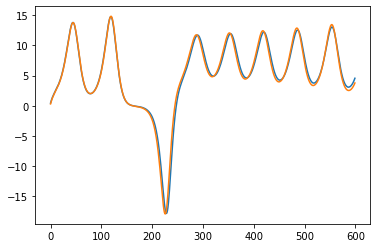

In [21]:
plt.plot(y_pred2[1:600+1,0])
plt.plot(X_test[400:,0])

In [22]:
plt.plot(y_pred2[1:600+1,1])
plt.plot(X_test[400:,1])

Error in callback <function flush_figures at 0x7f9b910c07a0> (for post_execute):


KeyboardInterrupt: 

# Second method : optimize initial condition of the latent states to forecast the initial condition of the observations

In [23]:
def get_initial_condition(model, time_series, train_series, dt,lr_init, err_tol = 1E-4, n_train = 10000, get_init_in_train_set = True):
    criterion = torch.nn.MSELoss()#reduction = 'sum')
    if get_init_in_train_set :
        print(time_series.shape)
        inp_init = get_init(time_series,time_series.shape[0],0.01,params['dim_Embedding'])
    else:
        min_idx = None
        inp_init = torch.rand(1,(train_series.shape[-1]+model.Int_net.Dyn_net.y_aug.shape[-1])).float()*0.0
        inp_init[:,:time_series.shape[-1]] = time_series.clone()[:1,:]
    init_cond_model = get_init_model(model,inp_init)
    optimizer = torch.optim.Adam(init_cond_model.parameters(), lr = lr_init)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor = 0.1, patience=205, verbose=True, min_lr = 0.0001)
    stop_cond = False
    count = 0
    while(stop_cond==False):
        # Forward pass: Compute predicted y by passing x to the model
        pred = init_cond_model(0.0,time_series.shape[0],dt)
        #pred1, grad, inp, aug_inp = modelRINN(test_vars[:1,:],dt, True, iterate = t)
        # Compute and print loss
        loss = torch.mean((pred[1:,0,:time_series.shape[-1]][torch.where(~torch.isnan(time_series))]- time_series[torch.where(~torch.isnan(time_series))])**2)
#        criterion(pred[1:,0,:time_series.shape[-1]], time_series[:,:])
        print(count,loss)
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
        count += 1
        if loss.detach().numpy()<err_tol or count>n_train:
            stop_cond = True
    return inp_init, init_cond_model.estimate_init

class get_init_model(torch.nn.Module):
        def __init__(self, model_Multi_RINN, inp_init):
            super(get_init_model, self).__init__()
            self.Multi_INT_net = model_Multi_RINN
            self.estimate_init = torch.nn.Parameter((inp_init.clone()))#torch.nn.Parameter(aug_inp[:1,:])
        def forward(self, t0, nb, dt):
            pred = self.Multi_INT_net(self.estimate_init, t0, nb, dt)[0]
            return pred

In [24]:
initial_cond_idx = 400
length_prior     = 50
train_series = torch.from_numpy(X_train).float()

model_Multi_RINN = Multi_INT_net(params)
for param in model_Multi_RINN.Int_net.parameters():
   param.requires_grad = False 

inp_init_knn, inp_init_opti = get_initial_condition(model_Multi_RINN, torch.from_numpy(X_test[initial_cond_idx:initial_cond_idx+length_prior,:1]).float(), train_series, 0.01,lr_init = 0.1, err_tol = 1E-4, n_train = 10000, get_init_in_train_set = True)

torch.Size([50, 1])
0 tensor(0.0126, grad_fn=<MeanBackward0>)
1 tensor(6.9263, grad_fn=<MeanBackward0>)
2 tensor(0.3332, grad_fn=<MeanBackward0>)
3 tensor(0.9603, grad_fn=<MeanBackward0>)
4 tensor(3.1416, grad_fn=<MeanBackward0>)
5 tensor(3.6211, grad_fn=<MeanBackward0>)
6 tensor(2.6196, grad_fn=<MeanBackward0>)
7 tensor(1.1952, grad_fn=<MeanBackward0>)
8 tensor(0.2512, grad_fn=<MeanBackward0>)
9 tensor(0.2157, grad_fn=<MeanBackward0>)
10 tensor(0.8896, grad_fn=<MeanBackward0>)
11 tensor(1.5509, grad_fn=<MeanBackward0>)
12 tensor(1.5821, grad_fn=<MeanBackward0>)
13 tensor(1.0635, grad_fn=<MeanBackward0>)
14 tensor(0.4940, grad_fn=<MeanBackward0>)
15 tensor(0.2297, grad_fn=<MeanBackward0>)
16 tensor(0.3047, grad_fn=<MeanBackward0>)
17 tensor(0.5574, grad_fn=<MeanBackward0>)
18 tensor(0.7766, grad_fn=<MeanBackward0>)
19 tensor(0.8222, grad_fn=<MeanBackward0>)
20 tensor(0.6726, grad_fn=<MeanBackward0>)
21 tensor(0.4084, grad_fn=<MeanBackward0>)
22 tensor(0.1714, grad_fn=<MeanBackward0>)
2

189 tensor(0.0008, grad_fn=<MeanBackward0>)
190 tensor(0.0008, grad_fn=<MeanBackward0>)
191 tensor(0.0008, grad_fn=<MeanBackward0>)
192 tensor(0.0008, grad_fn=<MeanBackward0>)
193 tensor(0.0008, grad_fn=<MeanBackward0>)
194 tensor(0.0008, grad_fn=<MeanBackward0>)
195 tensor(0.0008, grad_fn=<MeanBackward0>)
196 tensor(0.0008, grad_fn=<MeanBackward0>)
197 tensor(0.0007, grad_fn=<MeanBackward0>)
198 tensor(0.0007, grad_fn=<MeanBackward0>)
199 tensor(0.0007, grad_fn=<MeanBackward0>)
200 tensor(0.0007, grad_fn=<MeanBackward0>)
201 tensor(0.0007, grad_fn=<MeanBackward0>)
202 tensor(0.0007, grad_fn=<MeanBackward0>)
203 tensor(0.0007, grad_fn=<MeanBackward0>)
204 tensor(0.0007, grad_fn=<MeanBackward0>)
205 tensor(0.0007, grad_fn=<MeanBackward0>)
206 tensor(0.0007, grad_fn=<MeanBackward0>)
207 tensor(0.0007, grad_fn=<MeanBackward0>)
208 tensor(0.0007, grad_fn=<MeanBackward0>)
209 tensor(0.0007, grad_fn=<MeanBackward0>)
210 tensor(0.0007, grad_fn=<MeanBackward0>)
211 tensor(0.0007, grad_fn=<Mean

KeyboardInterrupt: 

In [ ]:
y_pred2=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init_knn
y_pred2[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred2[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[k,:],(1,params['dim_Embedding']))).float())

In [ ]:
y_pred3=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init_opti
y_pred3[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred3[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred3[k,:],(1,params['dim_Embedding']))).float())

In [ ]:
plt.plot(y_pred2[1:600,0])
plt.plot(X_test[400:,0])

In [ ]:
plt.plot(y_pred3[1:600,0])
plt.plot(X_test[400:,0])

# finding an initial condition for noisy and missing observations 

In [ ]:
observations = np.copy(X_test[:,:1])*np.nan
observations[::8,:] = X_test[::8,:1] + np.random.normal(0,2,X_test[::8,:1].shape[0]).reshape(X_test[::8,:1].shape[0],1)

In [ ]:
initial_cond_idx = 400
length_prior     = 100
train_series = torch.from_numpy(X_train).float()
inp_init_knn, inp_init_opti = get_initial_condition(model_Multi_RINN, torch.from_numpy(observations[initial_cond_idx:initial_cond_idx+length_prior,:1]).float(), train_series, 0.01,lr_init = 0.02, err_tol = 1E-1, n_train = 500, get_init_in_train_set = True)

In [ ]:
y_pred3=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init_opti
y_pred3[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred3[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred3[k,:],(1,params['dim_Embedding']))).float())

In [ ]:
plt.plot(y_pred3[1:600,0])
plt.plot(X_test[400:,0])
plt.plot(observations[400:,0],'*')